In [1]:
import rasterio
import numpy as np
import matplotlib as mpl
import subprocess
from matplotlib import pyplot
from rasterio.merge import merge
import geopandas as gpd

## Merge GeoTIFF Data of each Band

In [21]:
file1 = 'LC08_L1TP_126051_20171206_20171223_01_T1'
file2 = 'LC08_L1TP_127051_20171213_20171223_01_T1'

date = '201712'

list1 = ['Data/B9/' + file1 + '_B9.TIF',
         'Data/B6/' + file1 + '_B6.TIF',
         'Data/B5/' + file1 + '_B5.TIF',
         'Data/B4/' + file1 + '_B4.TIF',
         'Data/B3/' + file1 + '_B3.TIF']

list2 = ['Data/B9/' + file2 + '_B9.TIF',
         'Data/B6/' + file2 + '_B6.TIF',
         'Data/B5/' + file2 + '_B5.TIF',
         'Data/B4/' + file2 + '_B4.TIF',
         'Data/B3/' + file2 + '_B3.TIF']



outFile = ['MERGED/' + date + '/' + 'B9.TIF',
           'MERGED/' + date + '/' + 'B6.TIF',
           'MERGED/' + date + '/' + 'B5.TIF',
           'MERGED/' + date + '/' + 'B4.TIF',
           'MERGED/' + date + '/' + 'B3.TIF',]

for i in range(5):
    listFile = [rasterio.open(f) for f in [list1[i], list2[i]]]

    dest, output_transform = merge(listFile)

    profile = listFile[0].profile
    profile['transform'] = output_transform
    profile['height'] = dest.shape[1]
    profile['width'] = dest.shape[2]

    with rasterio.open(outFile[i], 'w', **profile) as dst:
        dst.write(dest)
        try:
            colormap = listFile[0].colormap(1)
            dst.write_colormap(1, colormap)
        except ValueError:
            pass

## Calculate NDVI

In [22]:
import os, math

for root, dir, filenames in os.walk('MERGED/'):
    for folder in dir:
        path = os.path.join('MERGED', folder)
        listFile = [path + '/B5.TIF',
                   path + '/B4.TIF']
        bandNIR, bandRed = (rasterio.open(f) for f in listFile)
        
        meta = bandNIR.meta
        meta['dtype'] = 'float32'
        
        print("Processing %s" % path)
        bandNIR = bandNIR.read(1)
        bandRed = bandRed.read(1)

        NDVI = np.zeros(rasterio.open(listFile[0]).shape, dtype=rasterio.float32)
        for i in range(NDVI.shape[0]):
            for j in range(NDVI.shape[1]):
                nir = bandNIR[i,j].astype(float)
                red = bandRed[i,j].astype(float)
                NDVI[i,j] = (nir - red) / (nir + red)
                if math.isnan(NDVI[i,j]):
                   NDVI[i,j] = 1
        with rasterio.open(path + '/NDVI.TIF', 'w', **meta) as dst:
            dst.write(NDVI, 1)

Processing MERGED/201706


/home/ahldt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/ahldt/.local/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Processing MERGED/201701
Processing MERGED/201708
Processing MERGED/201709
Processing MERGED/201711
Processing MERGED/201712
Processing MERGED/201612
Processing MERGED/201704
Processing MERGED/201702
Processing MERGED/201705
Processing MERGED/201707
Processing MERGED/201703
Processing MERGED/201710



## Calculate NDWI

In [23]:
import os, math

for root, dir, filenames in os.walk('MERGED/'):
    for folder in dir:
        path = os.path.join('MERGED', folder)
        listFile = [path + '/B5.TIF',
                   path + '/B3.TIF']
        bandNIR, bandGreen = (rasterio.open(f) for f in listFile)
        
        meta = bandNIR.meta
        meta['dtype'] = 'float32'
        
        print("Processing %s" % path)
        bandNIR = bandNIR.read(1)
        bandGreen = bandGreen.read(1)

        NDWI = np.zeros(rasterio.open(listFile[0]).shape, dtype=rasterio.float32)
        for i in range(NDWI.shape[0]):
            for j in range(NDWI.shape[1]):
                nir = bandNIR[i,j].astype(float)
                green = bandGreen[i,j].astype(float)
                NDWI[i,j] = (green - nir) / (green + nir)
                if math.isnan(NDWI[i,j]):
                   NDWI[i,j] = -1
        with rasterio.open(path + '/NDWI.TIF', 'w', **meta) as dst:
            dst.write(NDWI, 1)

Processing MERGED/201706


/home/ahldt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/ahldt/.local/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Processing MERGED/201701
Processing MERGED/201708
Processing MERGED/201709
Processing MERGED/201711
Processing MERGED/201712
Processing MERGED/201612
Processing MERGED/201704
Processing MERGED/201702
Processing MERGED/201705
Processing MERGED/201707
Processing MERGED/201703
Processing MERGED/201710


## Calculate NDWI 2

In [26]:
import os, math

for root, dir, filenames in os.walk('MERGED/'):
    for folder in dir:
        path = os.path.join('MERGED', folder)
        listFile = [path + '/B6.TIF',
                   path + '/B3.TIF']
        bandSWIR, bandGreen = (rasterio.open(f) for f in listFile)
        
        meta = bandSWIR.meta
        meta['dtype'] = 'float32'
        
        print("Processing %s" % path)
        bandSWIR = bandSWIR.read(1)
        bandGreen = bandGreen.read(1)

        NDWI2 = np.zeros(rasterio.open(listFile[0]).shape, dtype=rasterio.float32)
        for i in range(NDWI2.shape[0]):
            for j in range(NDWI2.shape[1]):
                swir = bandSWIR[i,j].astype(float)
                green = bandGreen[i,j].astype(float)
                NDWI2[i,j] = (green - swir) / (green + swir)
                if math.isnan(NDWI2[i,j]):
                    NDWI2[i,j] = -1
        with rasterio.open(path + '/NDWI2.TIF', 'w', **meta) as dst:
            dst.write(NDWI2, 1)

Processing MERGED/201706


/home/ahldt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/ahldt/.local/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Processing MERGED/201701
Processing MERGED/201708
Processing MERGED/201709
Processing MERGED/201711
Processing MERGED/201712
Processing MERGED/201612
Processing MERGED/201704
Processing MERGED/201702
Processing MERGED/201705
Processing MERGED/201707
Processing MERGED/201703
Processing MERGED/201710


## NDVI, NDWI, NDWI2

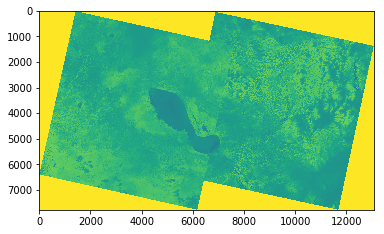

In [2]:
%matplotlib inline
NDVI = rasterio.open('MERGED/201705/NDVI.TIF').read(1)
pyplot.imshow(NDVI)

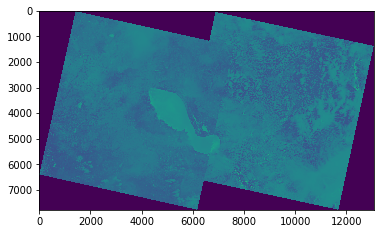

In [3]:
NDWI = rasterio.open('MERGED/201705/NDWI.TIF').read(1)
pyplot.imshow(NDWI)

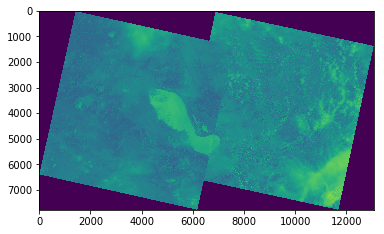

In [4]:
NDWI2 = rasterio.open('MERGED/201705/NDWI2.TIF').read(1)
pyplot.imshow(NDWI2)

## Read Shapefile

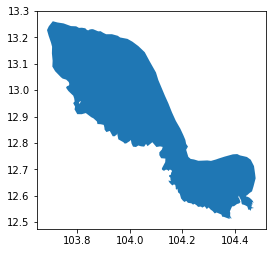

In [5]:
cambodia_waterbodies_path = 'water-bodies-09-08-2016'
df = gpd.read_file(cambodia_waterbodies_path)
tonlesap = df[df.name == 'Boeung Tonle Sap']
tonlesap.plot();

In [6]:
from rasterio.crs import CRS
from rasterio.warp import transform_geom
from shapely.geometry import shape, mapping, Polygon, MultiPolygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

In [22]:
src_ndvi = rasterio.open('MERGED/201705/NDVI.TIF')
trans = src_ndvi.transform
src_ndwi = rasterio.open('MERGED/201705/NDWI.TIF')
src_ndwi2 = rasterio.open('MERGED/201705/NDWI2.TIF')

/home/ahldt/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
import rasterio.mask
tonlesap_shape = tonlesap.geometry.values[0]
tonlesap_geom = mapping(tonlesap_shape)
tonlesap_shape = [transform_geom(df.crs, src_ndvi.crs, tonlesap_geom)]

Create new shape to mask : Rectangle ~

In [25]:
inf = float("inf")
x0, y0, x1, y1 = [inf, -inf, -inf, inf] #top-left, bottom-right
for x, y in tonlesap_shape[0]['coordinates'][0]:
    if x0 > x:
        x0 = x
    if x1 < x:
        x1 = x
    if y0 < y:
        y0 = y
    if y1 > y:
        y1 = y
new_coordinates = [{'type': 'Polygon', 'coordinates': [[(x0-1000, y0+1000),(x1+1000, y0+1000), 
                                                        (x1+1000, y1-1000), (x0-1000, y1-1000)]]}]
ndvi, _ = rasterio.mask.mask(src_ndvi, new_coordinates, crop=True)
ndwi, _ = rasterio.mask.mask(src_ndwi, new_coordinates, crop=True)
ndwi2, _ = rasterio.mask.mask(src_ndwi2, new_coordinates, crop=True)

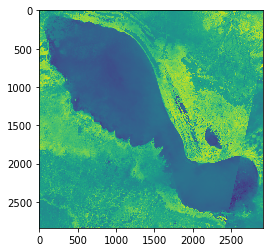

In [26]:
pyplot.imshow(ndvi.squeeze())

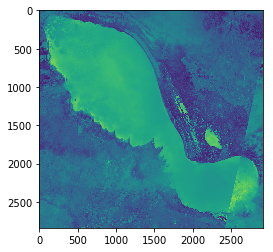

In [27]:
pyplot.imshow(ndwi.squeeze())

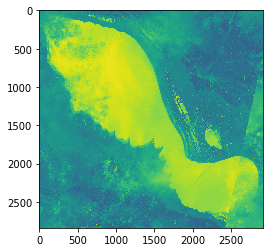

In [28]:
pyplot.imshow(ndwi2.squeeze())

In [ ]:
new_nir = np.zeros(nir.shape)
m = nir.shape[1]
n = nir.shape[2]

for i in range(m):
    for j in range(n):
        val = nir[0,i,j]
        new_nir[0,i,j] = val if val < 0 else 1

## BFS-like

In [ ]:
def insideMatrix(x, y, m, n):
    if x < 0 or x >= m or y < 0 or y >= n:
        return False
    return True

In [ ]:
from queue import Queue
dx = [0,1,0,-1]
dy = [1,0,-1,0]

visited = np.zeros((nir.shape[1], nir.shape[2])).astype('bool')
final_nir = np.zeros((nir.shape[1], nir.shape[2]))

u0, v0 = 1000, 1000

q = Queue()
q.put((u0, v0))
visited[u0, v0] = True
countPixel = 0

while not q.empty():
    u, v = q.get()
    final_nir[u, v] = -1
    countPixel += 1
    for k in range(4):
        _u, _v = u + dx[k], v + dy[k]
        if not insideMatrix(_u, _v, nir.shape[1], nir.shape[2]): 
            continue
        if new_nir[0, _u, _v] < 0 and not visited[_u, _v]:
            visited[_u, _v] = True
            q.put((_u, _v))
    
pyplot.imshow(final_nir)
print('Areas Calculated in KM^2 = {0}'.format(countPixel * 900 / 1000000))

## Linear Regression

In [205]:
areaCalculated = [2381.5134, 2492.3394, 2455.1217, 2256.5034, 1642.392, None, None, 2387.547, 2601.6435, None, 2354.175,
                 2480.7996]
#5, 6/17: Error
